In this notebook, we introduce a tensor-based implementation of the HOG feature extractor, built in Keras and Tensorflow. It is, to our knowledge, the first of its kind. To restrict all operations to the tensor domain, we approximate the previously employed histogram bin construction methodology, known as voting via bi-linear interpolation, as the scalar projection of each angle vector onto each separate bin unit vector. Since this is defined as a simple dot product between the two aforementioned vectors, we can implement this as a Convolution2D operation, with the angle vectors as the input and the bin unit vectors as the filters, with each filter representing a single unit vector that operates on every angle vector in the image. A Relu activation function operates on the output to curb the influence of negative projections. The reshaping required for the bin operations broken into separate depthwise convolution2D operations (via Tensorflow) followed via a Concatenation. 

As both Tensorflow allows the automatic computation of gradients, unlike the SkImage HOG, our Tensor-based HOG enables backpropagation through HOG. This opens up an array of previously unexplored possibilities. It is for instance now possible to have HOG as an intermediary layer, meaning that instead of having the raw images as inputs, we first pass them through a series of convolution layers and then into HOG, theoretically enabling the creation of a more powerful feature extractor. We shall test this premise in the not too distant future.

For this notebook, we simply compare the performance of the outputs of the flattened bin array on both a keras dense logictic regiression and a Scipy logistic regression. We use centered samples. The results show that a simple scipy logictic regression on the output predictions prerforms significantly better than the intergrated keras Dense layer. Our current aim is to correct this.

In [265]:
# Importing packages
import numpy as np
import keras 
from keras import backend as K
from keras.layers import Conv2D, Input, Dense, Lambda, multiply, AveragePooling2D, Concatenate, Flatten
from keras.engine.topology import Layer
from keras.models import Model
from keras.utils import np_utils
import tensorflow as tf
import pickle
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

K.set_image_dim_ordering('tf')
K.set_image_data_format('channels_last')

In [266]:
# Opening pre-configured training and testing data.
# Balanced classes and equal test/train split
# Order: Samples are balanced, shuffled, split into training and testing sets, and then fed into the data generator separately.
# Images are geneated through Keras' ImageDataGenerator, with the following settings:
# rotation_range=180, zoom_range=0.2, horizontal_flip=True, vertical_flip =True, fill_mode = "nearest")

file = open("train_y_hog.dat",'rb')
train_y_n = pickle.load(file)
file.close()

file = open("test_y_hog.dat",'rb')
test_y_n = pickle.load(file)
file.close()

file = open("train_x_hog.dat",'rb')
train_x_n = pickle.load(file)
file.close()

file = open("test_x_hog.dat",'rb')
test_x_n = pickle.load(file)
file.close()

In [267]:
test_y_n.shape

(24600,)

In [268]:
# Defining Values
bins = 8         # number of bins in histogram
w = 2*np.pi/bins     # width of each bin
centers = np.arange(-np.pi, np.pi, w) + 0.5*w   #centers of each bin

cell_size = 8   # Each cell will contain cell_size^2 pixels
block_size = 2  # Each block will contain block_size^2 pixels
batch_size = 100  

In [269]:
if train_x_n.shape[0]%batch_size != 0:
    
    # Slicing off end of samples to ensure train_y.shape[0]%batch_size == 0
    train_y = train_y_n[:-(train_y_n.shape[0]%batch_size)]
    test_y = test_y_n[:-(test_y_n.shape[0]%batch_size)]
    
    # Slicing off end of samples to ensure train_x.shape[0]%batch_size == 0
    # Adding dimention for the colour chanels (It's greyscale, hence only 1)
    train_x = train_x_n.reshape((train_x_n.shape[0], train_x_n.shape[1], train_x_n.shape[2], 1))[:-(train_x_n.shape[0]%batch_size), :, :, :]
    test_x = test_x_n.reshape((test_x_n.shape[0], test_x_n.shape[1], test_x_n.shape[2], 1))[:-(test_x_n.shape[0]%batch_size), :, :, :]

# Special case (-0 indices returns zero images)
elif train_x_n.shape[0]%batch_size == 0:
    train_y = train_y_n
    test_y = test_y_n
    
    train_x = train_x_n.reshape((train_x_n.shape[0], train_x_n.shape[1], train_x_n.shape[2], 1))
    test_x = test_x_n.reshape((test_x_n.shape[0], test_x_n.shape[1], test_x_n.shape[2], 1))
    
else:
    print ("Biggly Error")

 # Convert class vectors to binary class matrices (for Keras Dense)
conf_train_y = np_utils.to_categorical(train_y, 2)
conf_test_y = np_utils.to_categorical(test_y, 2)

In [270]:
# Defining Weights for the vertical and horizontal convolutions to calculate the image gradients
prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).reshape((1, 3, 3, 1, 1))
prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).reshape((1, 3, 3, 1, 1))

cent = np.vstack((np.sin(centers), np.cos(centers))).reshape((1, 1, 1, 2, 8))

In [271]:
# Generating Filters for the Bin Operations
def create_bin_filters(bin_dim):
    filters = np.zeros((bin_dim**2, bin_dim, bin_dim))

    count = 0 
    for i in range(bin_dim):
        for j in range(bin_dim):
            filters[count, i, j] = 1
            count += 1
    return filters   

In [272]:
# bin_dim must be 2
# Increasing this will require the adding of some more tf.nn.depthwise_conv2d functions. There is one for each element in a single filter (i.e bin_dim^2)

b_flt = create_bin_filters(2)
bin_filters_n = b_flt.reshape((b_flt.shape[0], b_flt.shape[1], b_flt.shape[2], 1)).repeat(bins, 3) # Simply copying each filter anlong the last axis to satisfy the required shape for weights array (see Tensorflow docs for tf.nn.depthwise_conv2d)

In [273]:
# Reshaping to satisfy required shape for weight array
bin_filters = bin_filters_n.reshape(bin_filters_n.shape[0], bin_filters_n.shape[1], bin_filters_n.shape[2], bin_filters_n.shape[3], 1).astype(np.float32)

In [274]:
bin_filters[0, :, :, 0, 0]

array([[ 1.,  0.],
       [ 0.,  0.]], dtype=float32)

In [275]:
# Model HyperParameters
cell_dim = 8
bin_dim = 2
bin_stride_length = 1
bs = bin_stride_length

# Number of cells along each dim 
cell_nb = 128//cell_dim
assert not 128 % cell_dim

In [276]:

filt1 = tf.convert_to_tensor(bin_filters[0, :, :, :, :])
filt2 = tf.convert_to_tensor(bin_filters[1, :, :, :, :])
filt3 = tf.convert_to_tensor(bin_filters[2, :, :, :, :])
filt4 = tf.convert_to_tensor(bin_filters[3, :, :, :, :])

In [277]:
def calculate_magnitudes(conv_stacked):
    mags = K.sqrt(conv_stacked[:, :, :, 0]**2 + conv_stacked[:, :, :, 1]**2)
    return mags

def calculate_angles(conv_stacked):
    angles = tf.atan2(conv_stacked[:, :, :, 1], conv_stacked[:, :, :, 0])
    return angles

def calculate_sin_cos(angles):
    sin = K.sin(angles)
    cos = K.cos(angles)
    sin_cos = K.stack([sin, cos], axis =-1)
    return sin_cos
   
def bins1(cells):
    c_bins = tf.nn.depthwise_conv2d(cells, filt1, strides = (1, bs, bs, 1), padding="VALID")
    return c_bins

def bins2(cells):
    c_bins = tf.nn.depthwise_conv2d(cells, filt2, strides = (1, bs, bs, 1), padding="VALID")
    return c_bins 

def bins3(cells):
    c_bins = tf.nn.depthwise_conv2d(cells, filt3, strides = (1, bs, bs, 1), padding="VALID")
    return c_bins

def bins4(cells):
    c_bins = tf.nn.depthwise_conv2d(cells, filt4, strides = (1, bs, bs, 1), padding="VALID")
    return c_bins

def bin_norm(bins_layer):
    bins_norm = tf.div(bins_layer, tf.expand_dims(tf.sqrt(tf.norm(bins_layer, axis=-1)+0.00000001), -1))
    return bins_norm

def bins_flatten(bins_norm):
    bins_flattened = tf.reshape(bins_norm, (batch_size, (cell_nb-bs)*(cell_nb-bs)*bins*(bin_dim**2)))
    return bins_flattened

def tensorflow_dense(bins_flattened):
    logistic = tf.layers.dense(inputs=bins_flattened, units = 2, activation="sigmoid")
    return logistic

"""
def bins_flatten(bins):
    bins_flatten = tf.reshape(bins, (-1))
    return bins_flatten

def bin_flatten_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  #only valid for 4D tensors
    shape = shape[0]*shape[1]*shape[2]*shape[3]
    return tuple(shape)
"""

'\ndef bins_flatten(bins):\n    bins_flatten = tf.reshape(bins, (-1))\n    return bins_flatten\n\ndef bin_flatten_output_shape(input_shape):\n    shape = list(input_shape)\n    assert len(shape) == 4  #only valid for 4D tensors\n    shape = shape[0]*shape[1]*shape[2]*shape[3]\n    return tuple(shape)\n'

In [278]:
flat_shape = batch_size*(cell_nb-bs)*(cell_nb-bs)*bins*(bin_dim**2)

In [279]:
flat_shape

720000

In [280]:
train_x.shape

(24600, 128, 128, 1)

In [281]:
# Building Model 

# Convolutions
inputs = Input(shape = (128, 128, 1))
x_conv = Conv2D(1, (3,3), strides=1, padding="same", data_format="channels_last", trainable=False, use_bias=False)(inputs)
y_conv = Conv2D(1, (3,3), strides=1, padding="same", data_format="channels_last", trainable=False, use_bias=False)(inputs)

# Stacking since it appears you cannot have more than a single input into a layer (i.e mags and angles)
conv_stacked = Concatenate(axis=-1)([x_conv, y_conv])

# Calculating the gradient magnitudes and angles
mags = Lambda(calculate_magnitudes, output_shape=(128, 128))(conv_stacked)
mags = Lambda(lambda x: K.stack((mags, mags), axis=-1))(mags)   # To enable sin_cos_vec 
angles = Lambda(calculate_angles, output_shape=(128, 128))(conv_stacked)

# Calculating the components of angles in the x and y direction
# Then multiplying by magnitudes, giving angle vectors
sin_cos = Lambda(calculate_sin_cos, output_shape=(128, 128, 2))(angles)
sin_cos_vec = multiply([sin_cos, mags])

# Applying each filter (representing a single bin unit vector) to every angle vector in the image.
# Result is an array with shape (img_height, img_width, bins) where each bin is contains an angle vectors contribution to each bin
# Relu activation function to remove negative projections (represented by negative scalar dot products).
votes = Conv2D(8, kernel_size=(1, 1), strides=(1, 1), activation="relu", trainable=False, bias=False)(sin_cos_vec) 

# A round about way of splitting the image (i.e vote array) into a bunch of non-overlapping cells of size (cell_size, cell_size)
# then concateting values at each bin level, giving shape of (cell_nb, cell_nb, bins)
# Result is an array of cells with histograms along the final axis
cells = AveragePooling2D(pool_size=cell_size, strides=cell_size)(votes)
cells = Lambda(lambda x: x * (cell_size**2))(cells)

# Bin Operations
# Assuming that bin shape = (2, 2)
# A round about way of grouping the cells into overlapping blocks of 2 * 2 cells each. 
# Two horizontally or vertically consecutive blocks overlap by two cells, that is, the block strides. 
# As a consequence, each internal cell is covered by four blocks (if bin_dim=2).
bins1_layer = Lambda(bins1, trainable=False)(cells)
bins2_layer = Lambda(bins2, trainable=False)(cells)
bins3_layer = Lambda(bins3, trainable=False)(cells)
bins4_layer = Lambda(bins4, trainable=False)(cells)
bins_layer = Concatenate(axis=-1)([bins1_layer, bins2_layer, bins3_layer, bins4_layer])

# normalize each block feature by its Euclidean norm
bins_norm_layer = Lambda(bin_norm)(bins_layer)
bin_flatten_layer = Lambda(bins_flatten)(bins_norm_layer)  # Flatten Resulting array

logistic_reg = Dense(2, activation = "sigmoid")(bin_flatten_layer)

C:\Users\fires\Anaconda3\envs\CSIRO\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, kernel_size=(1, 1), strides=(1, 1), activation="relu", trainable=False, use_bias=False)`


In [301]:
model_mags = Model(inputs=inputs, outputs=mags)
model_angles = Model(inputs=inputs, outputs=angles)
model_cells = Model(inputs=inputs, outputs=cells)
model_flatten = Model(inputs=inputs, outputs=bin_flatten_layer)
model = Model(inputs=inputs, outputs=logistic_reg)

In [283]:
model.summary()

In [284]:
np.asarray(model.layers[9].get_weights()).shape

(1, 1, 1, 2, 8)

In [285]:
model.layers[1].set_weights(prewitt_x)
model.layers[2].set_weights(prewitt_y)
model.layers[9].set_weights(cent)

model_mags.layers[1].set_weights(prewitt_x)
model_mags.layers[2].set_weights(prewitt_y)

model_angles.layers[1].set_weights(prewitt_x)
model_angles.layers[2].set_weights(prewitt_y)

model_cells.layers[1].set_weights(prewitt_x)
model_cells.layers[2].set_weights(prewitt_y)
model_cells.layers[9].set_weights(cent)

In [286]:
img_nb = 1

In [287]:
pred_mags = model_mags.predict(train_x[:batch_size, :, :, :], batch_size=batch_size)
pred_angles = model_angles.predict(train_x[:batch_size, :, :, :], batch_size=batch_size)
pred_cells = model_cells.predict(train_x[:batch_size, :, :, :], batch_size=batch_size)

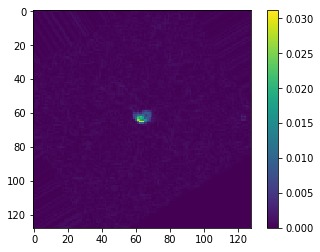

In [288]:
plt.imshow(pred_mags[img_nb, :, :, 0])
plt.colorbar()
plt.show()

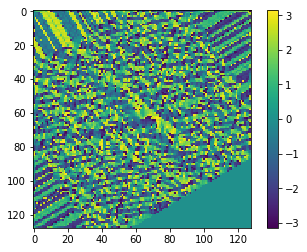

In [289]:
plt.imshow(pred_angles[img_nb, :, :])
plt.colorbar()
plt.show()

In [290]:
print (pred_angles.max())
print (pred_angles.min())

3.14159
-3.14159


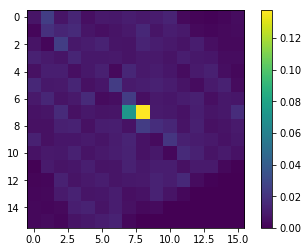

0.137545
0.0


In [291]:
bin_nbs = 7
plt.imshow(pred_cells[img_nb, :, :, bin_nbs])
plt.colorbar()
plt.show()

print (pred_cells[img_nb, :, :, bin_nbs].max())
print (pred_cells[img_nb, :, :, bin_nbs].min())

In [293]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.fit(train_x, conf_train_y, epochs=25, batch_size=batch_size, validation_data=(test_x, conf_test_y))

Train on 24600 samples, validate on 24600 samples
Epoch 1/25
24600/24600 [==============================] - 1244s 51ms/step - loss: 0.5717 - acc: 0.7167 - val_loss: 0.5795 - val_acc: 0.7340
Epoch 2/25
24600/24600 [==============================] - 842s 34ms/step - loss: 0.5526 - acc: 0.7217 - val_loss: 0.5735 - val_acc: 0.7251
Epoch 3/25
24600/24600 [==============================] - 773s 31ms/step - loss: 0.5412 - acc: 0.7295 - val_loss: 0.5710 - val_acc: 0.7289
Epoch 4/25
24600/24600 [==============================] - 404s 16ms/step - loss: 0.5350 - acc: 0.7334 - val_loss: 0.5701 - val_acc: 0.7292
Epoch 5/25
24600/24600 [==============================] - 258s 11ms/step - loss: 0.5319 - acc: 0.7339 - val_loss: 0.5686 - val_acc: 0.7331
Epoch 6/25
24600/24600 [==============================] - 266s 11ms/step - loss: 0.5267 - acc: 0.7400 - val_loss: 0.5683 - val_acc: 0.7329
Epoch 7/25
24600/24600 [==============================] - 255s 10ms/step - loss: 0.5218 - acc: 0.7426 - val_loss: 0

In [302]:
train_HOG = model_flatten.predict(train_x, batch_size=batch_size)
test_HOG = model_flatten.predict(test_x, batch_size=batch_size)
print ("Done")

Done


In [303]:
# Logistic Regression
clf = LogisticRegression(max_iter=500)
clf = clf.fit(train_HOG, train_y)

In [304]:
score = clf.score(test_HOG, test_y)
score

0.77532520325203247